## Function Overview: `resize`

This function processes an input image to crop a square region around the largest detected contour, typically used to isolate a prominent feature like a Petri dish.

### Key Steps:
1. **Convert to Grayscale**:
   - The input image is converted to grayscale using OpenCV's `cvtColor`.

2. **Binary Thresholding**:
   - A binary mask is created to separate foreground from background by thresholding pixel intensity.

3. **Contour Detection**:
   - The contours of the binary image are found, representing distinct objects.

4. **Largest Contour Identification**:
   - The largest contour, assumed to be the target object, is selected based on area.

5. **Bounding Box and Center Calculation**:
   - The bounding box and center of the largest contour are determined.
   - The dimensions of the square crop are set to ensure the entire contour fits within the square.

6. **Square Crop**:
   - A square region is cropped around the center of the largest contour, maintaining aspect ratio.

7. **Output**:
   - Returns the cropped image and the crop's bounding box coordinates.

This function is useful for preprocessing images where isolating and centering a key feature is required, such as in computer vision tasks involving objects or regions of interest.


In [1]:
def resize(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a binary mask
    _, binary = cv2.threshold(gray, 65, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (assuming it is the petri dish)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Determine the size of the square
    side_length = max(w, h)

    # Calculate the center of the bounding box
    center_x = x + w // 2
    center_y = y + h // 2

    # Calculate the coordinates for the square crop
    new_x = max(0, center_x - side_length // 2)
    new_y = max(0, center_y - side_length // 2)
    new_x_end = min(image.shape[1], center_x + side_length // 2)
    new_y_end = min(image.shape[0], center_y + side_length // 2)

    # Crop the image to the square
    cropped_image = image[new_y:new_y_end, new_x:new_x_end]

    return cropped_image, (new_x, new_y, side_length, side_length)

## Function Overview: `dataset_generator_with_saving`

This function generates and saves square patches from images and masks for a given dataset. It organizes the patches into a structured directory for use in machine learning workflows.

### Key Steps:
1. **Input and Output Setup**:
   - Reads images and masks from specified directories.
   - Creates output directories for saving patches.

2. **Resizing and Cropping**:
   - Calls a `resize` function to crop and center objects in the images and masks.
   - Scales the images and masks by a given `scaling_factor`.

3. **Patch Generation**:
   - Splits images and masks into square patches of size `patch_size`.
   - Pads smaller patches at the edges to ensure uniform size.

4. **Saving Patches**:
   - Saves patches with unique names in organized folders for images and masks.

### Output:
- Patches are saved to:
  - `base_output_dir/dataset_type_images/`
  - `base_output_dir/dataset_type_masks/`

This function is ideal for preprocessing large datasets into smaller, manageable chunks for model training and evaluation.


In [3]:
import glob
import os
import cv2
import numpy as np

def dataset_generator_with_saving(dataset, dataset_type, patch_size, scaling_factor, base_output_dir):
    """
    Generates and saves patches into a new directory structure.

    Args:
    - dataset_type (str): The type of dataset ('train', 'val', etc.).
    - patch_size (int): Size of the square patches (e.g., 128x128).
    - scaling_factor (float): Scale factor for resizing images/masks.
    - base_output_dir (str): Base directory where patched dataset will be saved.

    Output:
    - Patched dataset stored in a new folder structure: `base_output_dir/dataset_type_images` and `base_output_dir/dataset_type_masks`.
    """
    # Input directories
    images_dir = f'{dataset}/{dataset_type}_images/{dataset_type}/'
    masks_dir = f'{dataset}/{dataset_type}_masks/{dataset_type}/'

    # Output directories
    output_images_dir = os.path.join(base_output_dir, f"{dataset_type}_images/{dataset_type}")
    output_masks_dir = os.path.join(base_output_dir, f"{dataset_type}_masks/{dataset_type}")
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_masks_dir, exist_ok=True)

    images_paths = glob.glob(os.path.join(images_dir, "*.png"))
    masks_paths = glob.glob(os.path.join(masks_dir, "*.tif"))

    print(f"Processing {dataset_type} dataset:")
    print(f"Found {len(images_paths)} images and {len(masks_paths)} masks.")

    images_paths.sort()
    masks_paths.sort()

    for img_path, mask_path in zip(images_paths, masks_paths):
        img = cv2.imread(img_path)
        img, (new_x, new_y, side_length, side_length) = resize(img)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)[new_y:new_y + side_length, new_x:new_x + side_length]


        if img is None or mask is None:
            print(f"Failed to read image or mask: {img_path}, {mask_path}")
            continue

        # Scale the images and masks
        if scaling_factor != 1:
            img = cv2.resize(img, (0, 0), fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (0, 0), fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_NEAREST)

        h, w = img.shape[:2]
        print(f"Processing {os.path.basename(img_path)} with dimensions {h}x{w}")

        for i in range(0, h, patch_size):
            for j in range(0, w, patch_size):
                # Ensure the patch size matches at edges
                img_patch = img[i:min(i+patch_size, h), j:min(j+patch_size, w)]
                mask_patch = mask[i:min(i+patch_size, h), j:min(j+patch_size, w)]

                # If patch is smaller than the required size, pad it
                if img_patch.shape[:2] != (patch_size, patch_size):
                    img_patch = cv2.copyMakeBorder(img_patch, 
                                                   0, patch_size - img_patch.shape[0], 
                                                   0, patch_size - img_patch.shape[1], 
                                                   cv2.BORDER_CONSTANT, value=0)
                    mask_patch = cv2.copyMakeBorder(mask_patch, 
                                                    0, patch_size - mask_patch.shape[0], 
                                                    0, patch_size - mask_patch.shape[1], 
                                                    cv2.BORDER_CONSTANT, value=0)

                # Save the patches
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                patch_name = f"{base_name}_{i}_{j}.png"

                cv2.imwrite(os.path.join(output_images_dir, patch_name), img_patch)
                cv2.imwrite(os.path.join(output_masks_dir, patch_name), mask_patch)

    print(f"Patches saved to {output_images_dir} and {output_masks_dir}")

### Apply the function created to generate patches for both train and validation sets

In [6]:
# Generate patched dataset for training and validation
dataset_generator_with_saving(
    dataset='Y2B_24_23_organized',
    dataset_type="train", 
    patch_size=256, 
    scaling_factor=1, 
    base_output_dir="Y2B_24_23_patched"
)

dataset_generator_with_saving(
    dataset='Y2B_24_23_organized',
    dataset_type="val", 
    patch_size=256, 
    scaling_factor=1, 
    base_output_dir="Y2B_24_23_patched"
)

Processing train dataset:
Found 330 images and 330 masks.
Processing 001_43-18-ROOT1-2023-08-08_pvd_OD001_Col0_02-Fish Eye Corrected.png with dimensions 2794x2794
Processing 001_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish Eye Corrected.png with dimensions 2794x2794
Processing 002_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_01-Fish Eye Corrected.png with dimensions 2794x2794
Processing 002_43-6-ROOT1-2023-08-08_pvd_OD001_Col0_01-Fish Eye Corrected.png with dimensions 2796x2796
Processing 003_43-18-ROOT1-2023-08-08_pvdCherry_OD01_f6h1_01-Fish Eye Corrected.png with dimensions 2796x2796
Processing 003_43-6-ROOT1-2023-08-08_pvd_OD0001_f6h1_03-Fish Eye Corrected.png with dimensions 2794x2794
Processing 004_43-11-ROOT1-2023-08-08_pvdCherry_OD0001_f6h1_03-Fish Eye Corrected.png with dimensions 2796x2796
Processing 004_43-17-ROOT1-2023-08-08_pvd_OD001_f6h1_04-Fish Eye Corrected.png with dimensions 2794x2794
Processing 005_43-18-ROOT1-2023-08-08_pvd_OD001_Col0_05-Fish Eye Corrected.png with di

### Check whether the images and the patch match

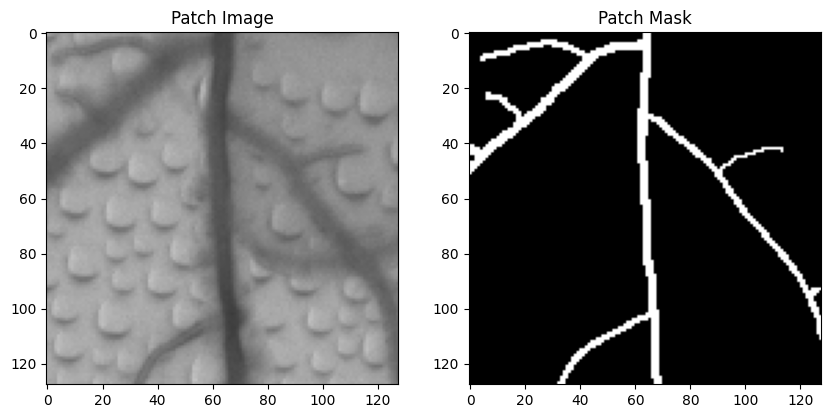

In [7]:
import matplotlib.pyplot as plt

# Example to visualize a patch
patch_image_path = "Y2B_24_23_patched_128/train_images/train/train_Alican_230858_im3_512_1792.png"
patch_mask_path = "Y2B_24_23_patched_128/train_masks/train/train_Alican_230858_im3_512_1792.png"

img_patch = cv2.imread(patch_image_path)
mask_patch = cv2.imread(patch_mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_patch, cv2.COLOR_BGR2RGB))
plt.title("Patch Image")
plt.subplot(1, 2, 2)
plt.imshow(mask_patch, cmap="gray")
plt.title("Patch Mask")
plt.show()